# Applying Zipf's law to *el país* collection with improved tokenization

Let's apply Zipf's law to a collection put together by scraping the news site *el país*. The code used to create the collection and the data used in this notebook can be found at this [notebook's repository](https://github.com/Benardi/bochica).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from math import log10
import re

#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

import pandas as pd
from plotnine import *
from numpy import arange
from nltk.util import ngrams    
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize, stem
from IPython.display import Markdown, display

%matplotlib inline
default_stopwords = set(stopwords.words('portuguese'))

In [3]:
from math import inf, sqrt
from functools import reduce

def search_best_c(df, search_range):

    """Searchs for best c parameter for a collection.

    Fits a range of 'c' to predict ranking using probability
    and assesses each fit by using the metric RMSE, this func
    returns the best 'c' and the lowest 'RMSE'.

    :param obj df: Pandas dataframe with the collection data.

    :return: c parameter that yielded the lowest rmse 

    :rtype: float
    
    :return: lowest rmse encountered 

    :rtype: float
    """
    
    rmse = 0
    best_c = None
    N = df.shape[0]
    best_rmse = inf
    
    for c in search_range:
        rmse = df["r"] - (c / df["Pr"] )
        rmse = list(map(lambda x: pow(x,2), rmse))
        rmse = reduce(lambda x,y: x+y, rmse)
        rmse = sqrt(rmse / N)
        if rmse < best_rmse:
            best_rmse = rmse
            best_c = c

    return best_c, best_rmse


def split_spread_words(corpus, delim):

    """ Split then spread alpha word with certain delimiters.

    Split words with alphabetical characters that have certain 
    delimiters then spread the resulting words across the corpus.

    :param list corpus: list of words.
    :param str delim: target delimiter.

    :return: updated list of words 

    :rtype: list
    """
    
    new_words = []
    for word in words:
        if any(c.isalnum() for c in word):
            new_words.extend(word.split(delim))
        else:
            new_words.append(word)

    return new_words


def gen_zipf_stats(freq_dist, data_grain):
    
    """ Calculate zipf related statistics in a dataframe.

    From a frequency distribution of words, calculates and 
    provides zipf statistics in the form of a dataframe

    :param dict freq_dist: frequency indexed by word.
    :param str data_gram: name of the n-gram (e.g bigram).

    :return: Zipf statistics and corpus in a df 

    :rtype: pandas.core.frame.DataFrame
    """
    
    df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=["Freq."])
    df = df.sort_values(by=['Freq.'], ascending=False)
    df = df.rename_axis(data_grain).reset_index()
    df = df.rename_axis('r').reset_index()
    df["r"] = df["r"].apply(lambda x: x + 1)
    df["ln(r)"] = df["r"].apply(lambda x: log10(x))
    df["Pr"] = df["Freq."] / df["Freq."].sum() 
    df["Pr(%)"] = df["Pr"].apply(lambda x: x * 100)
    df["ln(Pr)"] = df["Pr"].apply(lambda x: log10(x))
    df["r * Pr"] = df["r"] * df["Pr"]
    df = df[[data_grain, 'Freq.', 'r', 'ln(r)', 'Pr','ln(Pr)', 'Pr(%)', 'r * Pr']]
    return df


def melt_merge_zipf_dfs(df_orig, df_stem, data_grain):

    """ Melt then merge zipf stats dfs with and without stemming.

    Melt two dfs containing zipf statistics generated with and
    without stemming and merge both into a single dataframe.
    
    :param pandas.core.frame.DataFrame df_orig: zipf df without stemming.
    :param pandas.core.frame.DataFrame dif_stem: zipf df with stemming
    :param str data_gram: name of the n-gram (e.g bigram).

    :return: resulting df containing both given dfs. 

    :rtype: pandas.core.frame.DataFrame
    """
    
    melt_df_orig = df_orig.melt(id_vars=[data_grain, 'Freq.','ln(Pr)'], var_name = "ranking",
                          value_vars=['ln(r)', 'ln(pred_r)'])
    melt_df_orig["stemming"] = "no_stemming"
    
    melt_df_stem = df_stem.melt(id_vars=[data_grain, 'Freq.','ln(Pr)'], var_name = "ranking",
                               value_vars=['ln(r)', 'ln(pred_r)'])
    melt_df_stem["stemming"] = "stemming"


    melt_df = pd.concat([melt_df_orig, melt_df_stem])

    return melt_df

## Load Data

In [4]:
data = pd.read_csv("../output/results.csv")
data.head()

,title,subtitle,author,date,section,text,url
0,“A sociedade foi Rubens Paiva não os facínora...,A decisão da juíza que proíbe as Forças Armada...,F. M.,30/03/2019 00:11:08,Brasil,A juíza federal Ivani Silva da Luz de Brasíli...,https://brasil.elpais.com/brasil/2019/03/26/po...
1,Justiça suspende decisão que proibia Forças Ar...,Liminar havia sido concedida na sexta-feira a ...,Marina Rossi,30/03/2019 16:17:59,Brasil,Menos de 24 horas depois de a juíza federal Iv...,https://brasil.elpais.com/brasil/2019/03/30/po...
2,Governo Bolsonaro prega “negacionismo históric...,Marcos Napolitano professor da USP diz que o...,Regiane Oliveira,04/04/2019 22:37:48,Brasil,Quando determinou que de 31 de março 1964 u...,https://brasil.elpais.com/brasil/2019/04/05/po...
3,Quando os pais de Gabo perceberam que tinham u...,Gustavo Tatis percorre o universo de García Má...,Jesús Ruiz Mantilla,07/03/2019 16:38:56,Cultura,Quando era pequeno Luisa e Gabriel se preo...,https://brasil.elpais.com/brasil/2019/03/06/cu...
4,Rádios canadenses banem músicas de Michael Jac...,Quebec Cogeco Media toma a decisão após queixa...,Jaime Porras Ferreyra,07/03/2019 16:12:37,Cultura,Desde a manhã da última segunda-feira e ...,https://brasil.elpais.com/brasil/2019/03/06/cu...


## *El país* collection (characteristics)

In [5]:
corpus = data["text"].apply(lambda x: word_tokenize(x)).sum()

words = [word for word in corpus]

# Remove words that don't have at least one alphabetical character 
words = [word for word in words if any(c.isalnum() for c in word)]

# Remove hyphen at end of word
words = [word[:-1] if word[-1] == '-' else word for word in words]

# Remove hyphen at beggining of word
words = [word[1:] if word[0] == '-' else word for word in words]

# Split words joined by en dash
words = [word for line in words for word in line.split('–')] 
words = [word for line in words for word in line.split('—')] # different encoding 

# Split words joined by dot if they are alphabetical
words = split_spread_words(words, '.')

# Remove lone punctuation from the splits
words = [word for word in words if any(c.isalnum() for c in word)]

# Remove stopwords
words = [word for word in words if word.lower() not in default_stopwords]

# Calculate bigrams
bigrams = list(ngrams(words, 2))

In [6]:
# Apply stemming
stemmer = stem.snowball.SnowballStemmer('portuguese')
stem_words = [stemmer.stem(word) for word in words]
stem_bigrams = [(stemmer.stem(word1),stemmer.stem(word2)) for word1, word2 in bigrams]

In [7]:
# calculate frequency distribution of words and bigrams
fdist = FreqDist(words)
bifdist = FreqDist(bigrams)
fdist_stem = FreqDist(stem_words)
bifdist_stem = FreqDist(stem_bigrams)

# number of words with more than 1000 occurrences
nw_1000 = len(list(filter(lambda x: x > 1000,fdist_stem.values())))

# number of words with exactly 1 occurrence
nw_1 = len(list(filter(lambda x: x== 1, fdist_stem.values())))

# number of bigrams with more than 100 occurrences
nb_100 = len(list(filter(lambda x: x > 100,bifdist_stem.values())))

# number of bigrams with exactly 1 occurrence
nb_1 = len(list(filter(lambda x: x== 1, bifdist_stem.values())))

In [8]:
display(Markdown("***"))
display(Markdown("### Statistics for *el país* collection (with stemming)"))
print("Total documents:               {}".format(data.shape[0]))
print("Total word occurrences:        {}".format(len(words)))
print("Vocabulary size:               {}".format(len(set(words))))
print("Words occurring > 1000 times:  {}".format(nw_1000))
print("Words occurring once:          {}".format(nw_1))
print("Bigrams occurring > 100 times: {}".format(nb_100))
print("Bigrams occurring once:        {}".format(nb_1))
display(Markdown("***"))

***

### Statistics for *el país* collection (with stemming)

Total documents:               249
Total word occurrences:        122286
Vocabulary size:               24996
Words occurring > 1000 times:  1
Words occurring once:          5461
Bigrams occurring > 100 times: 1
Bigrams occurring once:        94416


***

In [9]:
df_w_stem = gen_zipf_stats(fdist_stem, 'Word')
df_w = gen_zipf_stats(fdist, 'Word')

display(Markdown("***"))
display(Markdown("### Most frequent *50* Words from *el país* collection (with stemming)"))
display(HTML(df_w_stem.head(50).to_html(index=False)))
display(Markdown("***"))

***

### Most frequent *50* Words from *el país* collection (with stemming)

Word,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr
é,1970,1,0.000000,0.016110,-1.792911,1.610978,0.016110
pod,636,2,0.301030,0.005201,-2.283920,0.520092,0.010402
anos,584,3,0.477121,0.004776,-2.320964,0.477569,0.014327
ser,537,4,0.602060,0.004391,-2.357402,0.439134,0.017565
outr,535,5,0.698970,0.004375,-2.359023,0.437499,0.021875
part,497,6,0.778151,0.004064,-2.391020,0.406424,0.024385
tod,494,7,0.845098,0.004040,-2.393650,0.403971,0.028278
país,457,8,0.903090,0.003737,-2.427461,0.373714,0.029897
govern,448,9,0.954243,0.003664,-2.436099,0.366354,0.032972
polít,433,10,1.000000,0.003541,-2.450889,0.354088,0.035409


***

In [10]:
df_bi_stem = gen_zipf_stats(bifdist_stem, 'Bigram')
df_bi = gen_zipf_stats(bifdist, 'Bigram')

display(Markdown("***"))
display(Markdown("### Most frequent *50* bigrams from *el país* collection (with stemming)"))
display(HTML(df_bi_stem.head(50).to_html(index=False)))
display(Markdown("***"))

***

### Most frequent *50* bigrams from *el país* collection (with stemming)

Bigram,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr
"(pod, ser)",107,1,0.000000,0.000875,-3.057989,0.087501,0.000875
"(dev, ser)",77,2,0.301030,0.000630,-3.200882,0.062968,0.001259
"(é, precis)",70,3,0.477121,0.000572,-3.242275,0.057243,0.001717
"(estad, unid)",59,4,0.602060,0.000482,-3.316521,0.048248,0.001930
"(red, soc)",55,5,0.698970,0.000450,-3.347010,0.044977,0.002249
"(ano, pass)",53,6,0.778151,0.000433,-3.363097,0.043341,0.002600
"(além, diss)",53,7,0.845098,0.000433,-3.363097,0.043341,0.003034
"(el, país)",49,8,0.903090,0.000401,-3.397177,0.040070,0.003206
"(milhõ, rea)",42,9,0.954243,0.000343,-3.464124,0.034346,0.003091
"(forc, armad)",40,10,1.000000,0.000327,-3.485313,0.032710,0.003271


***

## Stemming errors

In [11]:
df_stem = pd.DataFrame({"Word" : words,"Stem": stem_words})
df_stem = df_stem.sort_values(by=['Word'], ascending=True)

display(Markdown("***"))
display(Markdown("### Word and inferred stem"))
display(HTML(df_stem.loc[lambda df : df.Word.map(lambda w: not any(c.isnumeric() for  c in w))]\
             .sample(10).to_html(index=False)))
display(Markdown("***"))

***

### Word and inferred stem

Word,Stem
silenciosa,silenc
partir,part
retrospectiva,retrospect
ocasião,ocasiã
Solari,solar
parte,part
criminosas,crimin
notícias,notíc
presidentes,president
volante,volant


***


#### False Positive

> Over-stemming is when two words with different stems are stemmed to the same root (false positive)

#### False Negative

> Under-stemming is when two words that should be stemmed to the same root are not (false negative). 

### Occurences in the *el país* collection

### False Positive

* (Estero, ester) (Ester, ester)
* (Coreia, cor) (Cores, cor)
* (Colin, colin) (Colinas, colin)
* (Cinc, cinc) (Cinco, cinc)
* (Charlie, charli) (Charlier, charli)
* (Carta, cart) (Carter, cart)
* (Brunom brun) (Bruneim brun)
* (Brun, brun) (Brunei, brun)
* (Bastos, bast) (Bastou, bast)
* (Andrea, andre) (Andrei, andre)
* (Amazon, amazon) (Amazônia, amazon)
* (Aqua, aqu) (Aqui, aqu)

### False Negative
* (Constituinte, constituint) (Constituição, constituiçã)
* (Campeões, campeõ) (Campeonato, campeonat)
* (Bíblia, bíbl) (Bíblico, bíblic)
* (Brasil, brasil) (Brasileira, brasileir)
* (Batalha, batalh) (Batalhão, batalhã)
* (arte, arte) (artes, artes)
* (Alto, alto) (Altos, altos)
* (Ano, ano) (Anual, anual)
* (armas, armas) (armados, armad)
* (apoia, apoia) (apoiador, apoiador)
* (America, amer) (American, American)
* (assistenciais, assistenc) (assistiram, assist)


#### What could be the consequences of such errors?

Such errors could lead to a mixup in the indexing of documents by assigning documents to the wrong topic and bundling together unrelated documents, which would lead to problems such as:

* Query returns documents of unrelated topics 
    + A query about *Amazônia* is filled with documents about the company *Amazon* as well because of a **false positive**.
* Query does not find related documents
    + A query about *Bíblia* doesn't return documents that have the term *Bíblico* instead of the term *Bíblia* because of a **false negative**.
 
>Ultimately these errors would severely degrade the quality of the service provided by the search engine.

## Rank vs Frequency

### Tuning the parameter c

In this section let's tune the parameter c using the quality metric *RMSE* as a point of reference.

#### Using words (1-grams)

In [12]:
word_c, word_rmse = search_best_c(df_w, arange(1e-20, 1, 2.5e-3))

display(Markdown("***"))
display(Markdown("##### Best parameter 'c'  for *el país* collection (no stemming)"))
print("\n    c: {}".format(word_c))
print(" rmse: {}".format(word_rmse))
display(Markdown("***"))

***

##### Best parameter 'c'  for *el país* collection (no stemming)


    c: 0.1525
 rmse: 2763.3165568911654


***

In [13]:
word_c_stem, word_rmse_stem = search_best_c(df_w_stem, arange(1e-20, 1, 2.5e-3))

display(Markdown("***"))
display(Markdown("##### Best parameter 'c'  for *el país* collection in (with stemming)"))
print("\n    c: {}".format(word_c_stem))
print(" rmse: {}".format(word_rmse_stem))
display(Markdown("***"))

***

##### Best parameter 'c'  for *el país* collection in (with stemming)


    c: 0.085
 rmse: 1409.3626421688314


***

* There's a visible improvement in the fit when *stemming* is used with the *RMSE* nearly dropping by half 

#### Using bigrams (2-grams)

In [14]:
bi_c, bi_rmse = search_best_c(df_bi, arange(1e-20, 1, 2.5e-3))
display(Markdown("***"))
display(Markdown("##### Best parameter 'c'  for *el país* collection (no stemming)"))
print("\n    c: {}".format(bi_c))
print(" rmse: {}".format(bi_rmse))
display(Markdown("***"))

***

##### Best parameter 'c'  for *el país* collection (no stemming)


    c: 0.47000000000000003
 rmse: 29133.055075157885


***

In [15]:
bi_c_stem, bi_rmse_stem = search_best_c(df_bi_stem, arange(1e-20, 1, 2.5e-3))
display(Markdown("***"))
display(Markdown("##### Best parameter 'c'  for *el país* collection (with stemming)"))
print("\n    c: {}".format(bi_c_stem))
print(" rmse: {}".format(bi_rmse_stem))
display(Markdown("***"))

***

##### Best parameter 'c'  for *el país* collection (with stemming)


    c: 0.4575
 rmse: 26655.02924320359


***

* There's improvement in the fit when *stemming* is used although not as big as in the case of 1-grams.

### Compare predicted with actual

#### Using words (1-grams)

##### Let's use the tuned *c* parameter to predict the ranking of words 

In [16]:
df_w["pred_r"] = (word_c / df_w["Pr"])
df_w["ln(pred_r)"] = df_w["pred_r"].apply(lambda x: log10(x))

df_w_stem["pred_r"] = (word_c / df_w_stem["Pr"])
df_w_stem["ln(pred_r)"] = df_w_stem["pred_r"].apply(lambda x: log10(x))
df_w_stem.head()

,Word,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr,pred_r,ln(pred_r)
0,é,1970,1,0.000000,0.016110,-1.792911,1.610978,0.016110,9.466302,0.976180
1,pod,636,2,0.301030,0.005201,-2.283920,0.520092,0.010402,29.321722,1.467189
2,anos,584,3,0.477121,0.004776,-2.320964,0.477569,0.014327,31.932560,1.504234
3,ser,537,4,0.602060,0.004391,-2.357402,0.439134,0.017565,34.727402,1.540672
4,outr,535,5,0.698970,0.004375,-2.359023,0.437499,0.021875,34.857224,1.542293


##### Let's melt and merge the dataframes containing the predictions to facilitate the visualization

In [17]:
melt_w = melt_merge_zipf_dfs(df_w, df_w_stem, 'Word')
melt_w.sample(5)

,Word,Freq.,ln(Pr),ranking,value,stemming
5650,impedimento,4,-4.485317,ln(r),3.752125,no_stemming
10162,exaltado,2,-4.786347,ln(r),4.007022,no_stemming
612,assunt,42,-3.464127,ln(r),2.787460,stemming
25511,stonecrest,1,-5.087377,ln(pred_r),4.270647,stemming
26579,atuais,14,-3.941249,ln(pred_r),3.124519,no_stemming


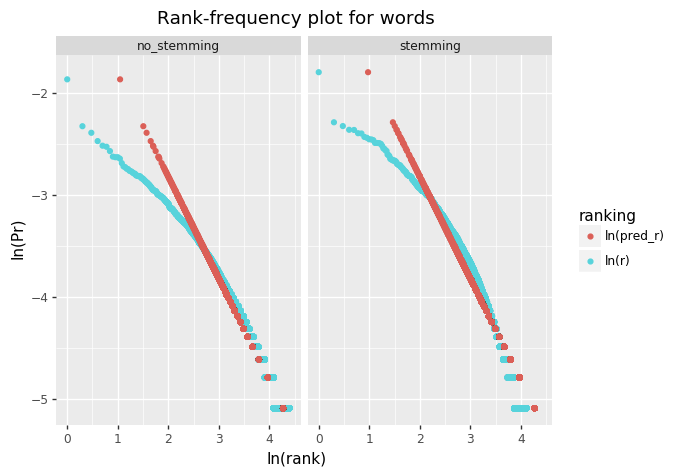

<ggplot: (8789151349547)>

In [18]:
(ggplot(melt_w)  
 + geom_point(aes('value','ln(Pr)', color="ranking")) 
 + labs(title="Rank-frequency plot for words", x="ln(rank)")
 + facet_wrap("stemming", ncol = 2)
)

The information reflected by the *RMSE* in the last section can also be seen here: 
* The curves in the case where stemming is used are much closer to each other than in the case where no stemming was used. This is visible looking at *ln(rank)* from 1 to 2.

***  

#### Using bigrams (2-grams)

##### Let's use the tuned *c* parameter to predict the ranking of words 

In [19]:
df_bi["pred_r"] = (bi_c / df_bi["Pr"])
df_bi["ln(pred_r)"] = df_bi["pred_r"].apply(lambda x: log10(x))

df_bi_stem["pred_r"] = (bi_c / df_bi_stem["Pr"])
df_bi_stem["ln(pred_r)"] = df_bi_stem["pred_r"].apply(lambda x: log10(x))
df_bi_stem.head()

,Bigram,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr,pred_r,ln(pred_r)
0,"(pod, ser)",107,1,0.000000,0.000875,-3.057989,0.087501,0.000875,537.139720,2.730087
1,"(dev, ser)",77,2,0.301030,0.000630,-3.200882,0.062968,0.001259,746.414935,2.872980
2,"(é, precis)",70,3,0.477121,0.000572,-3.242275,0.057243,0.001717,821.056429,2.914373
3,"(estad, unid)",59,4,0.602060,0.000482,-3.316521,0.048248,0.001930,974.134746,2.988619
4,"(red, soc)",55,5,0.698970,0.000450,-3.347010,0.044977,0.002249,1044.980909,3.019108


##### Let's melt and merge the dataframes containing the predictions to facilitate the visualization

In [20]:
melt_bi = melt_merge_zipf_dfs(df_bi, df_bi_stem, 'Bigram')
melt_bi.sample(5)

,Bigram,Freq.,ln(Pr),ranking,value,stemming
3460,"(brasileiros, vivendo)",2,-4.786343,ln(r),3.539202,no_stemming
57935,"(líd, primeir)",1,-5.087373,ln(r),4.762949,stemming
155830,"(faz, obra)",1,-5.087373,ln(pred_r),4.759471,no_stemming
165412,"(perig, diz)",1,-5.087373,ln(pred_r),4.759471,stemming
18730,"(múltipl, ident)",1,-5.087373,ln(r),4.272561,stemming


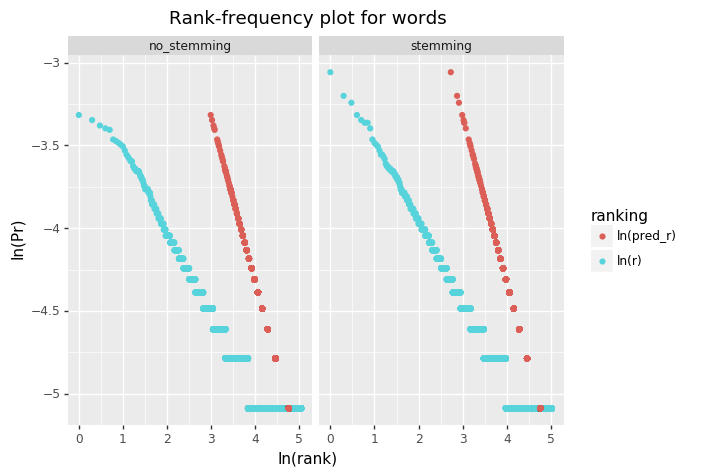

<ggplot: (8789142718528)>

In [21]:
(ggplot(melt_bi)  
 + geom_point(aes('value','ln(Pr)', color="ranking")) 
 + labs(title="Rank-frequency plot for words", x="ln(rank)")
 + facet_wrap("stemming", ncol = 2)
)

* An improvement can be seen  when *stemming* is used, in particular when rank is around 0 to 1.
* Improvement seems less substantial than in the case of 1-grams.

***

## Predicting Proportion

In [22]:
actual_nwords = df_w_stem['Freq.'].value_counts()
actual_prop = df_w_stem.groupby(['Freq.'])['Pr'].agg('sum')

df_prop = pd.DataFrame({'n':actual_prop.index, 'actual_#words':actual_nwords.values,
                        'actual_prop': actual_prop.values})

df_prop["pred_prop"] = df_prop["n"].apply(lambda n: (1 / (n *(n + 1))))

df_prop = df_prop[['n','pred_prop', 'actual_prop', 'actual_#words']]
df_prop.columns = ["Number of occurrences (n)", 'Predicted Proportion (1/n(n+1))',
                   'Actual Proportion', 'Actual Number of Words']

display(Markdown("### Proportions of words occurring n times (with stemming)"))
display(HTML(df_prop.head(10).to_html(index=False)))
display(Markdown("***"))

### Proportions of words occurring n times (with stemming)

Number of occurrences (n),Predicted Proportion (1/n(n+1)),Actual Proportion,Actual Number of Words
1,0.500000,0.044658,5461
2,0.166667,0.030944,1892
3,0.083333,0.024704,1007
4,0.050000,0.020902,639
5,0.033333,0.020239,495
6,0.023810,0.017124,349
7,0.017857,0.015971,279
8,0.013889,0.014523,222
9,0.011111,0.011702,164
10,0.009091,0.013411,159


***

In [23]:
actual_nbi = df_bi_stem['Freq.'].value_counts()
actual_propbi = df_bi_stem.groupby(['Freq.'])['Pr'].agg('sum')

df_propbi = pd.DataFrame({'n':actual_propbi.index, 'actual_#bigrams':actual_nbi.values,
                        'actual_propbi': actual_propbi.values})

df_propbi["pred_prop"] = df_propbi["n"].apply(lambda n: (1 / (n *(n + 1))))

df_propbi = df_propbi[['n','pred_prop', 'actual_propbi', 'actual_#bigrams']]
df_propbi.columns = ["Number of occurrences (n)", 'Predicted Proportion (1/n(n+1))',
                   'Actual Proportion', 'Actual Number of Bigrams']

display(Markdown("### Proportions of bigrams occurring n times (with stemming)"))
display(HTML(df_propbi.head(10).to_html(index=False)))
display(Markdown("***"))

### Proportions of bigrams occurring n times (with stemming)

Number of occurrences (n),Predicted Proportion (1/n(n+1)),Actual Proportion,Actual Number of Bigrams
1,0.500000,0.772098,94416
2,0.166667,0.107012,6543
3,0.083333,0.036652,1494
4,0.050000,0.020313,621
5,0.033333,0.012226,299
6,0.023810,0.007801,159
7,0.017857,0.006354,111
8,0.013889,0.004383,67
9,0.011111,0.003827,52
10,0.009091,0.002617,32


***